<style type="text/css">
#image {
  float:left;
  border-right:1px;
  width:145px;
  height:145px;
  margin-top:1px;
  margin-left:50px;
  padding:1px;
  background-color:#ffffff;
}
#subject {
  float:left;
  width:500px;
  border-radius: 10px; 
  height:130px;
  margin-top:6px;
  padding:1px;
  background-color:#b0bc04;
}
</style>

<div id="image">
<img src="https://www.imt-atlantique.fr/sites/default/files/ecole/IMT_Atlantique_logo.png" WIDTH=240 HEIGHT=240>
</div>
<div id="subject">
<CENTER>
</br>

<font size="5">TAF MCE - UE Computer Vision | Project : Visual tracking of video objects </font></br></div>

<CENTER>
P.-H. Conze <span style="color:blue">pierre-henri.conze@imt-atlantique.fr</span> - 
R. Fablet <span style="color:blue">ronan.fablet@imt-atlantique.fr</span> - 
A. Colin <span style="color:blue">acolin@groupcls.com</span>
<CENTER>
</CENTER>
</div> 

## Purpose of the project

Implement the methodology described in the article and apply it in the context of **visual tracking of video objects** within image sequences. Spefically, the targeted application consists in estimating for the whole sequence the location of a manually defined region of interest in the first image, called **reference image**. Development will be done in python language and can use functions from librairies such as openCV, scikit-image, scikit-learn, keras... 

In [1]:
import numpy as np
import cv2
from skimage import io
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import img_as_ubyte
import distutils.dir_util
from skimage.measure import regionprops
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.filters import sobel

## Data

You have 6 video sequences containing a **variable number of images** (from 26 to 196). You can evaluate your method with these videos and compare it with the approaches implemented by the other groups as well as the baseline provided below. The **training sequences** (bag, bear, book, camel, rhino, swan) are available on Moodle or here: https://drive.google.com/file/d/1HrVlHV_M3ouWxk8TQWQgsOO5hDxsFAN9/view?usp=sharing

A binary mask is associated to each image to locate the object of interest (foreground object). Except for the reference image, these **groundtruth masks** can only be used for the evaluation of the implemented method. 

**Test sequences** will be provided at the end of the project.

In [2]:
name = 'swan' # name of the sequence : bag, bear, book, camel, rhino, swan
im_begin, im_end = 1, 26              # reference image (1) and last image (varies depending on the sequence)
output_folder = './results/'+name+'/' # result folder
distutils.dir_util.mkpath(output_folder) # creation of the folder output_folder

['results', 'results/swan']

Let us visualize some images with associated groundtruth masks.

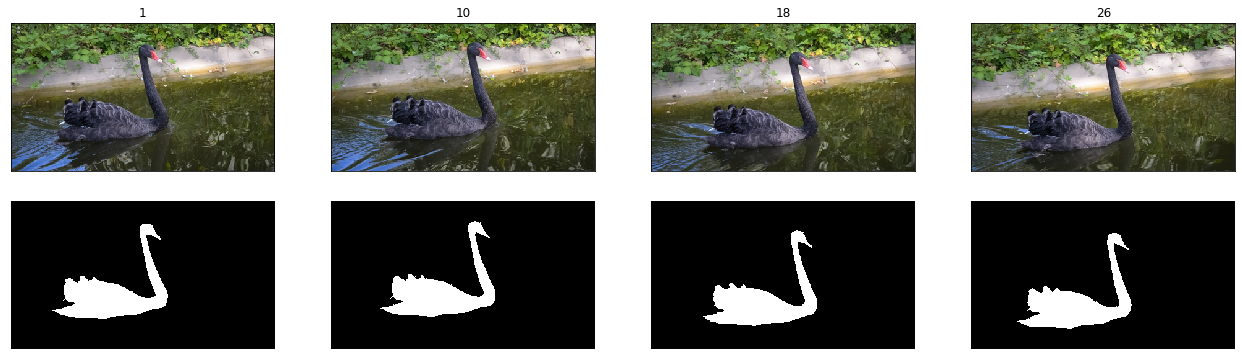

In [3]:
plt.figure(figsize=(22, 6))
for idx, im in enumerate([1,10,18,26]):
    img_current = io.imread('./sequences-train/'+name+'/%0*d.bmp'%(3,im))
    mask_current = io.imread('./sequences-train/'+name+'/%0*d.png'%(3,im))
    plt.subplot(2,4,idx+1), plt.title('%i' %(im)), plt.imshow(img_current), plt.xticks([]), plt.yticks([])
    plt.subplot(2,4,idx+5), plt.imshow(mask_current,cmap='gray'), plt.xticks([]), plt.yticks([])
    plt.axis('off')
plt.show()

## Assessment

The **DICE_assessment()**, **db_eval_boundary()** and **centroid_assessment()** functions provided below will allow you to evaluate the implemented method. These functions take as inputs both groundtruth and estimated masks of the foreground object. 

**DICE_assessment()** evaluates the overlap between the two masks while **db_eval_boundary()** quantifies the quality of the estimated contours. Each function returns a score between 0 (poor quality) and 100 (perfect quality).

**centroid_assessment()** comptes the Euclidean distance between groundtruth and estimated centroids.

In [4]:
def DICE_assessment(groundtruth, estimated, label=255):
    A = groundtruth == label
    B = estimated == label              
    TP = len(np.nonzero(A*B)[0])
    FN = len(np.nonzero(A*(~B))[0])
    FP = len(np.nonzero((~A)*B)[0])
    DICE = 0
    if (FP+2*TP+FN) != 0: 
        DICE = float(2)*TP/(FP+2*TP+FN)
    return DICE*100

In [5]:
def db_eval_boundary(foreground_mask,gt_mask,bound_th=0.008):
    """
    Compute mean,recall and decay from per-frame evaluation.
    Calculates precision/recall for boundaries between foreground_mask and
    gt_mask using morphological operators to speed it up.

    Arguments:
        foreground_mask (ndarray): binary segmentation image.
        gt_mask         (ndarray): binary annotated image.

    Returns:
        F (float): boundaries F-measure
    """
    assert np.atleast_3d(foreground_mask).shape[2] == 1

    bound_pix = bound_th if bound_th >= 1 else \
            np.ceil(bound_th*np.linalg.norm(foreground_mask.shape))

    # Get the pixel boundaries of both masks
    fg_boundary = seg2bmap(foreground_mask);
    gt_boundary = seg2bmap(gt_mask);

    from skimage.morphology import binary_dilation,disk

    fg_dil = binary_dilation(fg_boundary,disk(bound_pix))
    gt_dil = binary_dilation(gt_boundary,disk(bound_pix))

    # Get the intersection
    gt_match = gt_boundary * fg_dil
    fg_match = fg_boundary * gt_dil

    # Area of the intersection
    n_fg     = np.sum(fg_boundary)
    n_gt     = np.sum(gt_boundary)

    #% Compute precision and recall
    if n_fg == 0 and  n_gt > 0:
        precision = 1
        recall = 0
    elif n_fg > 0 and n_gt == 0:
        precision = 0
        recall = 1
    elif n_fg == 0  and n_gt == 0:
        precision = 1
        recall = 1
    else:
        precision = np.sum(fg_match)/float(n_fg)
        recall    = np.sum(gt_match)/float(n_gt)

    # Compute F measure
    if precision + recall == 0:
        F = 0
    else:
        F = 2*precision*recall/(precision+recall);

    return F*100.

def seg2bmap(seg,width=None,height=None):
    """
    From a segmentation, compute a binary boundary map with 1 pixel wide
    boundaries.  The boundary pixels are offset by 1/2 pixel towards the
    origin from the actual segment boundary.

    Arguments:
        seg     : Segments labeled from 1..k.
        width   : Width of desired bmap  <= seg.shape[1]
        height  : Height of desired bmap <= seg.shape[0]

    Returns:
        bmap (ndarray):	Binary boundary map.
    """

    seg = seg.astype(np.bool)
    seg[seg>0] = 1

    assert np.atleast_3d(seg).shape[2] == 1

    width  = seg.shape[1] if width  is None else width
    height = seg.shape[0] if height is None else height

    h,w = seg.shape[:2]

    ar1 = float(width) / float(height)
    ar2 = float(w) / float(h)

    assert not (width>w | height>h | abs(ar1-ar2)>0.01),\
        'Can''t convert %dx%d seg to %dx%d bmap.'%(w,h,width,height)

    e  = np.zeros_like(seg)
    s  = np.zeros_like(seg)
    se = np.zeros_like(seg)

    e[:,:-1]    = seg[:,1:]
    s[:-1,:]    = seg[1:,:]
    se[:-1,:-1] = seg[1:,1:]

    b        = seg^e | seg^s | seg^se
    b[-1,:]  = seg[-1,:]^e[-1,:]
    b[:,-1]  = seg[:,-1]^s[:,-1]
    b[-1,-1] = 0

    if w == width and h == height:
        bmap = b
    else:
        bmap = np.zeros((height,width))
        for x in range(w):
            for y in range(h):
                if b[y,x]:
                    j = 1+np.floor((y-1)+height / h)
                    i = 1+np.floor((x-1)+width  / h)
                    bmap[j,i] = 1;

    return bmap

In [6]:
def centroid_assessment(groundtruth,estimated):
    a = regionprops(groundtruth)
    b = regionprops(estimated)
    return np.linalg.norm(np.array(a[0].centroid)-np.array(b[0].centroid))

#  Baseline method

The **baseline** code below shows, as an indication, the implementation of a possible methodology (among others) to meet the project requirements. 

Let us consider a sequence of $N$ RGB images $\{I_{n}\}$ with $n\in \{1,\ldots,N\}$ where $I_{1}$ is the so-called reference image. Here, we estimate the long term motion between each image $I_{n}$ with $n \neq 1$ and the reference image $I_{1}$ by means of an optical flow estimator which processes the pairs $\{I_{n},I_{1}\}$ independently.

In this example, an openCV implementation of **Farnebäck's optical flow estimator** (G. Farnebäck, “Two-frame motion estimation based on polynomial expansion,” Image Analysis, pp. 363–370, 2003) is used.


In [7]:
def farneback(im1, im2):
    return cv2.calcOpticalFlowFarneback(im1, im2, None, pyr_scale=0.5, levels=3, winsize=7, iterations=3, poly_n=5, poly_sigma=1.2, flags=0) # None

Once the optical flow fields have been estimated, the **propagate_mask()** function below can propagate the groundtruth segmentation mask from $I_{1}$ to $I_{n}$.

In [8]:
def propagate_mask(flow, img_current, mask_begin):
    new_mask = np.zeros(shape=img_current.shape[:2], dtype=np.uint8)
    for x in range(img_current.shape[0]):
        for y in range(img_current.shape[1]):
            x_, y_ = np.rint(x+flow[x,y,1]).astype(np.int), np.rint(y+flow[x,y,0]).astype(np.int)
            if (x_>=0) and (x_<img_current.shape[0]) and (y_>=0) and (y_<img_current.shape[1]):
                if mask_begin[x_,y_] > 0:
                    new_mask[x,y] = 255
    return new_mask

In [9]:
img_begin = io.imread('./sequences-train/'+name+'/%0*d.bmp'%(3,im_begin))
mask_begin = io.imread('./sequences-train/'+name+'/%0*d.png'%(3,im_begin))

dices, fmeasures, centroid_dist, visu = [], [], [], []
for im in range(im_begin+1,im_end+1):
    print(im)
    img_current = io.imread('./sequences-train/'+name+'/%0*d.bmp'%(3,im))
    mask_current = io.imread('./sequences-train/'+name+'/%0*d.png'%(3,im))
    flow = farneback(img_as_ubyte(rgb2gray(img_current)), img_as_ubyte(rgb2gray(img_begin)))
    propagation = propagate_mask(flow, img_current, mask_begin)
    io.imsave(output_folder+'prop-%0*d.png'%(3,im), propagation)
    visu.append(mark_boundaries(mark_boundaries(img_current, mask_current, color=(0,1,0)), propagation, color=(1,0,0)))
    io.imsave(output_folder+'bound-%0*d.bmp'%(3,im), visu[-1])
    dices.append(DICE_assessment(mask_current, propagation))
    fmeasures.append(db_eval_boundary(mask_current, propagation))
    centroid_dist.append(centroid_assessment(mask_current, propagation))

2


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


3


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


4


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


5


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


6


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


7


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


8


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


9


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


10


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


11


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


12


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


13


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


14


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


15


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


16


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


17


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


18


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


19


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


20


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


21


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


22


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


23


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


24


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


25


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


26


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


## Result visualization

Once your method is implemented, you will be able to display the evolution of **DICE**, **F-measure** scores and **distance between centroids** along the video sequences...

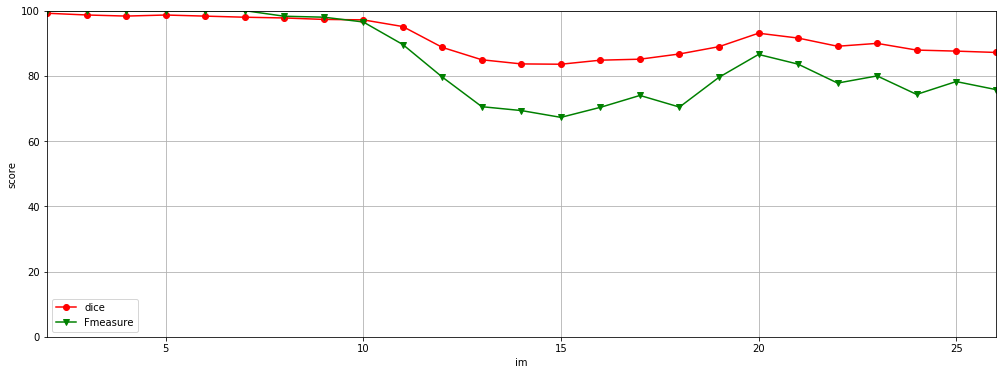

In [10]:
x = range(im_begin+1,im_end+1)
plt.figure(figsize=(17, 6))
plt.plot(x,dices,marker='o',color='r')
plt.plot(x,fmeasures,marker='v',color='g')
plt.xlim((im_begin+1,im_end))
plt.ylim((0,100))
plt.ylabel('score')
plt.xlabel("im")
plt.grid()
plt.legend(['dice', 'Fmeasure'])
plt.savefig(output_folder+'eval.png')
plt.show()

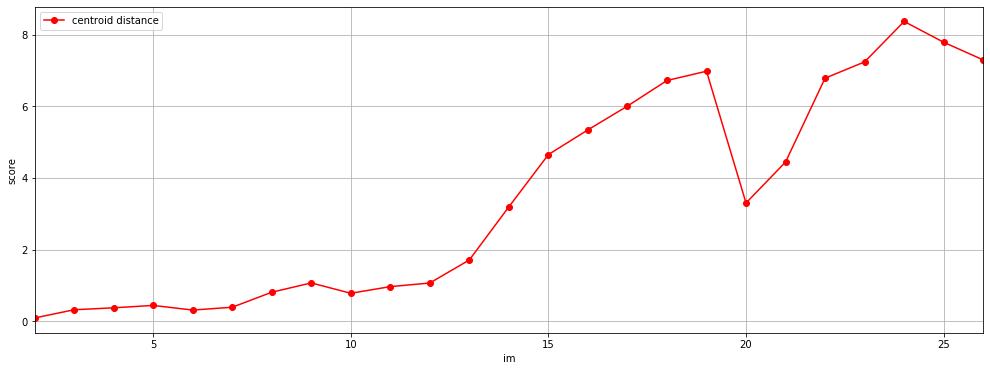

In [11]:
x = range(im_begin+1,im_end+1)
plt.figure(figsize=(17, 6))
plt.plot(x,centroid_dist,marker='o',color='r')
plt.xlim((im_begin+1,im_end))
plt.ylabel('score')
plt.xlabel("im")
plt.grid()
plt.legend(['centroid distance'])
plt.savefig(output_folder+'eval-centroid.png')
plt.show()

... and view the obtained **tracking results**!

<Figure size 432x288 with 0 Axes>

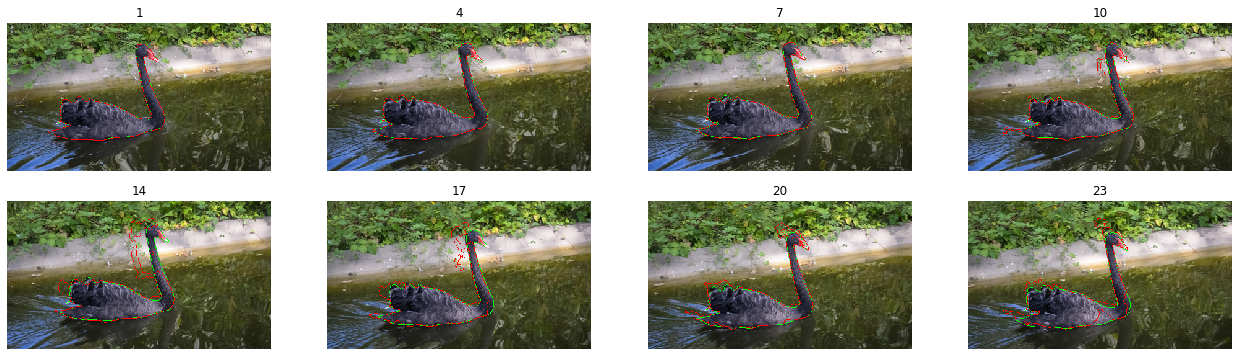

In [12]:
plt.figure()
plt.figure(figsize=(22, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    im = np.int(np.floor(i*(im_end/8)+im_begin-1))
    plt.imshow(visu[im])
    plt.title('%i' %(im+1))
plt.show()

## Superpixel decomposition

Superpixels are visual primitives generated by the aggregation of neighbouring pixels sharing similar characteristics. This tool can be exploited during the project. An example of decomposition using the Felzenszwalb, SLIC, Quickshift and Watershed methods is provided below:

Felzenszwalb number of segments: 320
SLIC number of segments: 219
Quickshift number of segments: 530


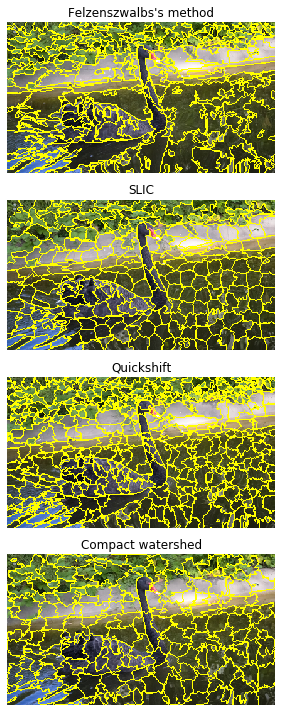

In [15]:
segments_fz = felzenszwalb(img_begin, scale=100, sigma=0.5, min_size=50)
segments_slic = slic(img_begin, n_segments=250, compactness=10, sigma=1)
segments_quick = quickshift(img_begin, kernel_size=3, max_dist=6, ratio=0.5)
gradient = sobel(rgb2gray(img_begin))
segments_watershed = watershed(gradient, markers=250, compactness=0.001)

print('Felzenszwalb number of segments: {}'.format(len(np.unique(segments_fz))))
print('SLIC number of segments: {}'.format(len(np.unique(segments_slic))))
print('Quickshift number of segments: {}'.format(len(np.unique(segments_quick))))

fig, ax = plt.subplots(4, figsize=(10, 10), sharex=True, sharey=True)

ax[0].imshow(mark_boundaries(img_begin, segments_fz))
ax[0].set_title("Felzenszwalbs's method")
ax[1].imshow(mark_boundaries(img_begin, segments_slic))
ax[1].set_title('SLIC')
ax[2].imshow(mark_boundaries(img_begin, segments_quick))
ax[2].set_title('Quickshift')
ax[3].imshow(mark_boundaries(img_begin, segments_watershed))
ax[3].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()